<a href="https://colab.research.google.com/github/MatteoRigoni/MachineLearningPlayground/blob/master/Progetto_MachineLearning_MatteoRigoni.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Previsione dell'affidabilità creditizia per il rilascio della carta di credito

Sei stato assunto dalla Pro National Bank come data scientist, il tuo primo incarico consiste nel realizzare un modello in grado di stimare l'affidabilità creditizia di un clienti, al fine di di aiutare il team dedicato a comprendere se accettare o meno la richiesta per il rilascio della carta di credito.

A tal fine ti vengono consegnati i dati anonimizzati di clienti che hanno già ottenuto la carta di credito e ne pagano regolarmente le rate.

I dati sono in un file CSV presente a questo indirizzo: https://proai-datasets.s3.eu-west-3.amazonaws.com/credit_scoring.csv

Il file credit_scoring.csv contiene le informazioni dei correntisti che hanno richiesto l’apertura di una linea di credito.

* ID: numero identificativo del cliente
* CODE_GENDER: sesso del cleinte
* FLAG_OWN_CAR: indicatore del possesso di un'automobile
* FLAG_OWN_REALTY: indicatore del possesso di una casa
* CNT_CHILDREN: numero di figli
* AMT_INCOME_TOTAL: reddito annuale
* NAME_INCOME_TYPE: tipo di reddito
* NAME_EDUCATION_TYPE: livello di educazione
* NAME_FAMILY_STATUS: Stato civile
* NAME_HOUSING_TYPE:
* DAYS_BIRTH: Numero di giorni trascorsi dalla nascita
* DAYS_EMPLOYED: Numero di giorni trascorsi dalla data di assunzione, se positivo indica il numero di giorni da quando è disoccupato
* FLAG_MOBIL: indicatore della presenza di un numero di cellulare
* FLAG_WORK_PHONE: indicatore della presenza di un numero di telefono di lavoro
* FLAG_PHONE: indicatore della presenza di un numero di telefono
* FLAG_EMAIL: indicatore della presenza di un indirizzo email
* OCCUPATION_TYPE: tipo di occupazione
* CNT_FAM_MEMBERS: numero di familiari
* TARGET: una variabile che vale 1 se il cliente ha una elevata affidabilità creditizia data dal pagamento costante delle rate e 0 altrimenti.

Devi realizzare un modello che preveda il target dato.

###PUNTO BONUS

Se ad un cliente viene negata la carta di credito, il team deve essere in grado di fornirgli una motivazione, questo vuol dire che il tuo modello deve fornire delle indicazioni facilmente interpretabili.








---



##Metodi helper usati durante gli step successivi

* *print_formatted*:  stampa di un titolo con separatore e contenuto sottostante
* *categorical_correlation_with_target*: calcolo della correlazione media di una variabile categoriale con la variabile target
* *evaluate_model*: stampa di classification report (precision,recall), confusion matrix (TP, TN, FP, FN), ROC AUC score

In [1]:
from IPython.display import display
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay

def print_formatted(title=None, text="", width=50):
  if title:
    title_line = "=" * width
    formatted_title = f"\n{title_line}\n{title}\n{title_line}"
  else:
    formatted_title = ""
  formatted_title = f"\n{title_line}\n{title}\n{title_line}"
  if isinstance(text, pd.DataFrame):
    print(formatted_title)
    display(text)
  else:
    output = f"{formatted_title}\n{str(text)}\n"
    print(output)

def categorical_correlation_with_target(df, categorical_feature, target):
    dummies = pd.get_dummies(df[categorical_feature], prefix=categorical_feature, drop_first=True)
    correlations = dummies.apply(lambda x: x.corr(df[target]))
    return correlations.mean()

def evaluate_model(title, y_test, y_pred, y_proba):
  print_formatted(title)
  print("--> Classification Report:\n")
  print(classification_report(y_test, y_pred), "\n")
  print("--> Confusion Matrix:\n")
  print(confusion_matrix(y_test, y_pred), "\n")
  print("--> ROC AUC Score:\n")
  roc_auc = roc_auc_score(y_test, y_proba)
  print(roc_auc, "\n")
  return (title, roc_auc)

##Premessa

L'analisi richiesta è di tipo supervisionato dove abbiamo un insieme di features e un'unica variabile target, che puoi assumere solamente due classi: SI o NO, per cui si tratta di una classificazione binaria.

#Caricamento dei dati

In [2]:
import pandas as pd
import numpy as np

URL = "https://proai-datasets.s3.eu-west-3.amazonaws.com/credit_scoring.csv"
df = pd.read_csv(URL, sep=',')
df = df.drop(df.columns[0], axis=1)

print_formatted("Size of dataset", df.shape)


Size of dataset
(338427, 18)



##Esplorazione del dataset originale

* metriche descrittive delle variabili
* considerazioni sui valori, come presenza di outliers
* verifica relazione tra le variabili


---

La variabile 'TARGET' è molto sbilanciata, sono molto più numerosi i casi a zero, ovvero che non garantiscono un pagamento costante della rata. Per questo motivo in fase di modellazione si valuterà di attribuire pesi in modo da mitigare questa discrepanza.

Sulle features numeriche e categoriche non risultano situazioni anomale, apparte la colonna 'DAYS_EMPLOYED' che sembra avere un valore predefinito di 365243 in corrispondenza dei soggetti non occupati. Sarà trattata nella fase di preprocessing. Per lo stesso motivo 'ATM_INCOME_TOTAL' ha un alto numero di osservazioni a zero.

Per valutare la correlazione non si una una matrice visiva a causa delle numerose variabili categoriche che verrebbero fuori usando i dummies. Si unificano invece le correlazioni di tutte le variabili, ordinandoli per importanza. Risulta che il reddito, età, giorni di lavoro e numero di familiari sono i principali elementi di influenza.


Info about dataset


,CNT_CHILDREN,AMT_INCOME_TOTAL,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,TARGET
count,338427.000000,3.384270e+05,338426.000000,338426.000000,338426.0,338426.000000,338426.000000,338426.000000,338426.000000,338427.000000
mean,0.428934,1.876543e+05,-15998.249644,60238.497163,1.0,0.211379,0.293302,0.105181,2.197228,0.087824
std,0.727990,1.106747e+05,4180.240053,138499.153147,0.0,0.408287,0.455276,0.306787,0.899570,0.283039
min,0.000000,2.610000e+04,-25201.000000,-17531.000000,1.0,0.000000,0.000000,0.000000,1.000000,0.000000
25%,0.000000,1.215000e+05,-19482.000000,-3116.000000,1.0,0.000000,0.000000,0.000000,2.000000,0.000000
50%,0.000000,1.620000e+05,-15622.000000,-1485.000000,1.0,0.000000,0.000000,0.000000,2.000000,0.000000
75%,1.000000,2.250000e+05,-12524.000000,-380.000000,1.0,0.000000,1.000000,0.000000,3.000000,0.000000
max,19.000000,6.750000e+06,-7489.000000,365243.000000,1.0,1.000000,1.000000,1.000000,20.000000,1.000000



Distribution of target variable
TARGET
0    308705
1     29722
Name: count, dtype: int64


Distribution of all features




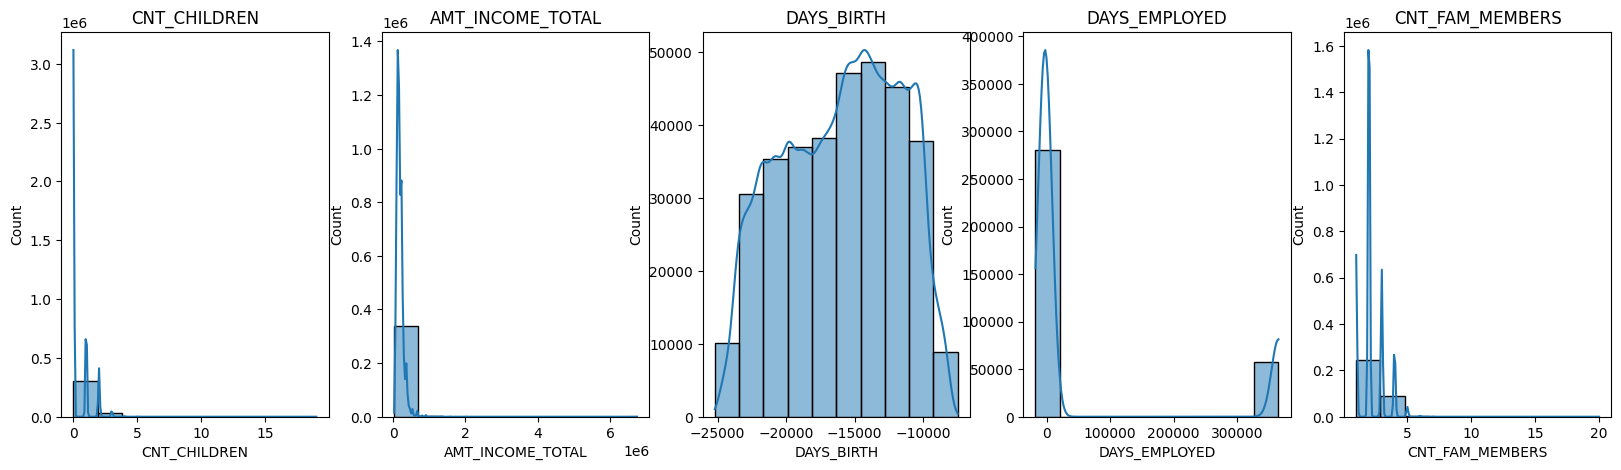

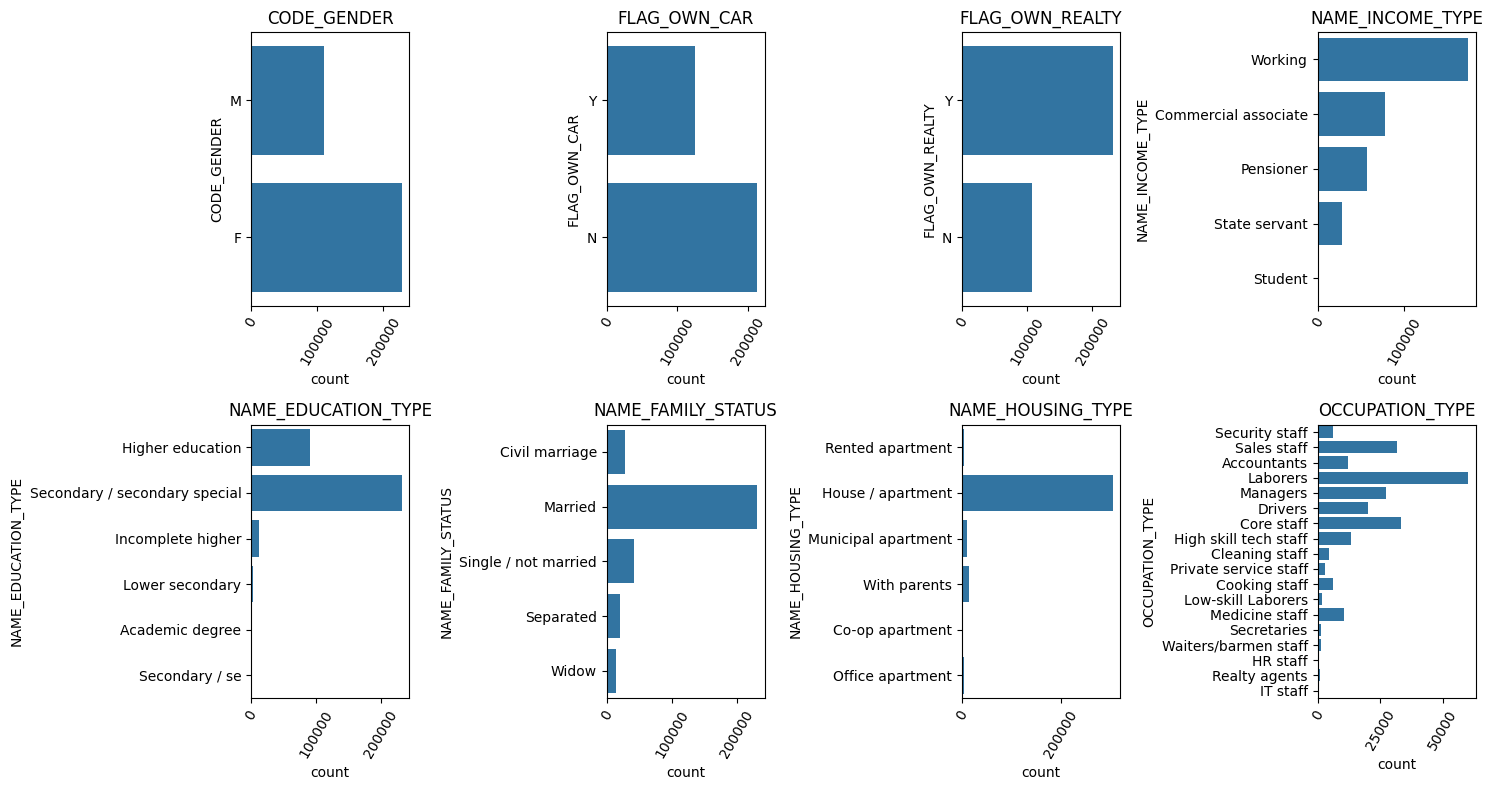


Features with highest correlation with target: 
TARGET              1.000000
AMT_INCOME_TOTAL    0.224395
DAYS_EMPLOYED      -0.145363
DAYS_BIRTH         -0.184662
dtype: float64



In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

print_formatted('Info about dataset', df.describe())
print_formatted('Distribution of target variable', df['TARGET'].value_counts())

print_formatted('Distribution of all features')

#Grafici variabili quantitative
numeric_features = ['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'CNT_FAM_MEMBERS']

fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 5))
axes = axes.flatten()

for i, feature in enumerate(numeric_features):
    sns.histplot(df[feature], bins=10, kde=True, ax=axes[i])
    axes[i].set_title(feature)

#Grafici variabili categoriche
categorical_features = ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE']

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(15, 8))
axes = axes.flatten()

for i, feature in enumerate(categorical_features):
    sns.countplot(df[feature], ax=axes[i])
    axes[i].set_title(feature)
    axes[i].tick_params(axis='x', rotation=60)

plt.subplots_adjust(hspace=0.5)
plt.tight_layout()
plt.show()

# Correlazine variabili
categorical_correlations = {}
for feature in categorical_features:
    categorical_correlations[feature] = categorical_correlation_with_target(df, feature, 'TARGET')

numeric_correlations = df[numeric_features + ['TARGET']].corr()['TARGET'].sort_values(ascending=False)
categorical_correlations_series = pd.Series(categorical_correlations)
all_correlations = pd.concat([categorical_correlations_series, numeric_correlations]).sort_values(ascending=False)
top_correlations = all_correlations[all_correlations.abs() > 0.1]

print_formatted("Features with highest correlation with target: ", top_correlations)

##Preprocessing dei dati

* analisi di eventuali dati mancanti
* trasformazione/normalizzazione delle variabili
* divisione delle variabili target dalle altre.


---

Il dataset è formato da 338.427 righe aventi 17 colonne (si rimuove la colonna ID in quanto inutile ai fini del modello).

La colonna "OCCUPATION_TYPE" ha molti valori vuoti, che in base al contesto possono essere sottointesi come "Unemployed", quindi si attribuisce per chiarezza questo valore.

C'è un solo record con numerosi flag nulli, il che fa pensare a un errore nel dataset, per cui visto che è un solo record su oltre 300.000 si esclude per non inquinare il modello.

Le variabili caetgoriche con due soli valori sono state rimappate nei valori interi 0/1, quelle categoriche che rappresentano una scala come 'NAME_EDUCATION_TYPE' sono state rimappate in formato numerico crescente in base al significato. Le altre sono state trattate con one-hot-encoding.

Si trasforma 'DAYS_BIRTH' che ha valori negativi in una colonna con gli anni del soggetto per semplificare il modello.

Si trasforma 'DAYS_EMPLOYED' che ha valori negativi in anni lavorativi. Inoltre per i non occupati c'è un valore di "default" molto alto, 365243, che si porta a zero in quanto più sensato per il significato della variabile.

In [4]:
from sklearn.preprocessing import StandardScaler

URL = "https://proai-datasets.s3.eu-west-3.amazonaws.com/credit_scoring.csv"
df = pd.read_csv(URL, sep=',')
df = df.drop(df.columns[0], axis=1)

print_formatted("Size of dataset", df.shape)
print_formatted("Top 5 record of dataset (before normalization)", df.head())

na_values = df.isnull().sum()
print_formatted("Original N/A values", na_values)

df = df.dropna(subset=['NAME_FAMILY_STATUS']).copy()
df['OCCUPATION_TYPE'].fillna('Unemployed', inplace=True)

binary_features = ['FLAG_OWN_CAR', 'FLAG_OWN_REALTY']
df[binary_features] = df[binary_features].applymap(lambda x: 1 if x == 'Y' else 0)

df['CODE_GENDER'] = df['CODE_GENDER'].map({'M': 0, 'F': 1})

education_types = {
    'Lower secondary': 1,
    'Secondary / secondary special': 2,
    'Secondary /se': 2,
    'Incomplete higher': 3,
    'Higher education': 4,
    'Academic degree': 5
}
df['NAME_EDUCATION_TYPE'] = df['NAME_EDUCATION_TYPE'].map(education_types)

df['AGE_YEARS'] = (-df['DAYS_BIRTH']) // 365
df = df.drop(columns=['DAYS_BIRTH'])

df['YEARS_EMPLOYED'] = df['DAYS_EMPLOYED'].apply(lambda x: 0 if x == 365243 else -x // 365)
df = df.drop(columns=['DAYS_EMPLOYED'])

flag_features = ['FLAG_MOBIL', 'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL']
df[flag_features] = df[flag_features].astype(int)

categorical_features = ['NAME_INCOME_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE']
df = pd.get_dummies(df, columns=categorical_features, drop_first=True)

numeric_features = ['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AGE_YEARS', 'YEARS_EMPLOYED', 'CNT_FAM_MEMBERS']
scaler = StandardScaler()

df[numeric_features] = scaler.fit_transform(df[numeric_features])

print_formatted("Top 5 record of dataset (after normalization)", df.head())

X = df.drop(columns=['TARGET'])
Y = df['TARGET']


Size of dataset
(338427, 18)


Top 5 record of dataset (before normalization)


,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,TARGET
0,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005.0,-4542.0,1.0,1.0,0.0,0.0,NaN,2.0,0
1,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005.0,-4542.0,1.0,1.0,0.0,0.0,NaN,2.0,0
2,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474.0,-1134.0,1.0,0.0,0.0,0.0,Security staff,2.0,0
3,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110.0,-3051.0,1.0,0.0,1.0,1.0,Sales staff,1.0,1
4,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110.0,-3051.0,1.0,0.0,1.0,1.0,Sales staff,1.0,1



Original N/A values
CODE_GENDER                 0
FLAG_OWN_CAR                0
FLAG_OWN_REALTY             0
CNT_CHILDREN                0
AMT_INCOME_TOTAL            0
NAME_INCOME_TYPE            0
NAME_EDUCATION_TYPE         0
NAME_FAMILY_STATUS          1
NAME_HOUSING_TYPE           1
DAYS_BIRTH                  1
DAYS_EMPLOYED               1
FLAG_MOBIL                  1
FLAG_WORK_PHONE             1
FLAG_PHONE                  1
FLAG_EMAIL                  1
OCCUPATION_TYPE        103342
CNT_FAM_MEMBERS             1
TARGET                      0
dtype: int64


Top 5 record of dataset (after normalization)


,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_EDUCATION_TYPE,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,...,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Unemployed,OCCUPATION_TYPE_Waiters/barmen staff
0,0,1,1,-0.589206,2.167124,4,1,1,0,0,...,False,False,False,False,False,False,False,False,True,False
1,0,1,1,-0.589206,2.167124,4,1,1,0,0,...,False,False,False,False,False,False,False,False,True,False
2,0,1,1,-0.589206,-0.679061,2,1,0,0,0,...,False,False,False,False,False,False,False,True,False,False
3,1,0,1,-0.589206,0.744031,2,1,0,1,1,...,False,False,False,False,False,True,False,False,False,False
4,1,0,1,-0.589206,0.744031,2,1,0,1,1,...,False,False,False,False,False,True,False,False,False,False


##Analisi dei modelli predittivi

Si effettua l'addestramento e valutazione del modello tramite diverse tecniche, per concludere con una comparazione degli score ottenuti.

In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split

RANDOM_SEED = 10

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=RANDOM_SEED, stratify=Y)

roc_auc_results = []

### K-Nearest Neighbors

L'utilizzo potrebbe essere appropriato in quanto clienti con caratteristiche simili e vicine tra loro avranno probabilmente uno stesso target. Inoltre è indipendente dalla distribuzione dei dati, che come visto nella pre-analisi per la maggioranza delle variabili non è 'normale'.

Per avere il valore ottimale dell'iperparametro "neighbors" si usa la funzione GridSearch, che utilizzando la cross-validation analizza qual'è il valore che dà un punteggio ROC AUC maggiore. (commentata visto che richiede parecchi minuti di elaborazione)

In [6]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

# param_grid = {'n_neighbors': list(range(3, 7))}

# knc = KNeighborsClassifier()

# grid_search = GridSearchCV(knc, param_grid, cv=5, scoring='roc_auc')
# grid_search.fit(X_train, y_train)

# best_n_neighbors = grid_search.best_params_['n_neighbors']
best_n_neighbors = 5

print(f"Value of 'n_neighbors' with highest AUC ROC score is : {best_n_neighbors}")

best_knc = KNeighborsClassifier(n_neighbors=best_n_neighbors)
best_knc.fit(X_train, y_train)

y_pred_knc = best_knc.predict(X_test)
y_proba_knc = best_knc.predict_proba(X_test)[:, 1]

roc_auc_results.append(evaluate_model("K-Nearest Neighbors", y_test, y_pred_knc, y_proba_knc))

Value of 'n_neighbors' with highest AUC ROC score is : 5

K-Nearest Neighbors


--> Classification Report:

              precision    recall  f1-score   support

           0       0.97      0.97      0.97     92611
           1       0.66      0.70      0.68      8917

    accuracy                           0.94    101528
   macro avg       0.82      0.83      0.83    101528
weighted avg       0.94      0.94      0.94    101528
 

--> Confusion Matrix:

[[89442  3169]
 [ 2659  6258]] 

--> ROC AUC Score:

0.9599073396930456 





> Si ottiene una precision e recall di 0.97 per la classe "Non affidabile". Questo è sicuramente più importante del caso contrario, in quanto è importante identificare in anticipo clienti potenzialmente non affidabili. Il punteggio ROC AUC è piuttosto alto: 0.95



###Naive Bayes

Si verificano le metriche per questo altoritmo anche se alcune sue caratteristiche non lo rendono molto adatto al modello, ad esempio l'algoritmo ipotizza che tutte le variabili siano indipendenti, ma in questo caso non è così, in quanto concettualmente dati di età, occupazione e reddito sono strettamente legati.

Un vantaggio è sicuramente dato dal fatto che computazionalmente è piuttosto leggero e può aiutarci visto che il dataset è abbastanza voluminoso, nel caso in cui debba essere rivalutato spesso.

In [7]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
gnb.fit(X_train, y_train)

y_pred_gnb = gnb.predict(X_test)
y_proba_gnb = gnb.predict_proba(X_test)[:, 1]

roc_auc_results.append(evaluate_model("Naive Bayes", y_test, y_pred_gnb, y_proba_gnb))


Naive Bayes


--> Classification Report:

              precision    recall  f1-score   support

           0       0.99      0.42      0.59     92611
           1       0.14      0.96      0.24      8917

    accuracy                           0.47    101528
   macro avg       0.56      0.69      0.41    101528
weighted avg       0.92      0.47      0.56    101528
 

--> Confusion Matrix:

[[38646 53965]
 [  345  8572]] 

--> ROC AUC Score:

0.8335930802153346 



> In questo caso la recall sui "Non Affidabili" è troppo bassa e si rischia di non identificare la maggior parte di questi soggetti, come si vede anche dalla confusion matrix dove ci sono 53.965 soggetti non affidabili classificati come affidabili.

###Support Vector Machine

SVM è consigliato per classificazioni binarie (che è il nostro caso) e quando il numero delle veriabili è elevato e in questo scenario ne abbiamo un discreto numero, per cui si effettua una stima anche di questo.

NOTA: A causa dei tempi di esecuzione troppo elevati si è deciso di operare il training solo su una frazione del dataset.

In [8]:
from sklearn.svm import SVC

X_train_sample = X_train.sample(frac=0.6, random_state=RANDOM_SEED)
y_train_sample = y_train.sample(frac=0.6, random_state=RANDOM_SEED)

svm = SVC(probability=True, random_state=RANDOM_SEED)
svm.fit(X_train_sample, y_train_sample)

y_pred_svm = svm.predict(X_test)
y_proba_svm = svm.predict_proba(X_test)[:, 1]

roc_auc_results.append(evaluate_model("SVM", y_test, y_pred_svm, y_proba_svm))


SVM


--> Classification Report:

              precision    recall  f1-score   support

           0       0.96      0.97      0.97     92611
           1       0.70      0.61      0.65      8917

    accuracy                           0.94    101528
   macro avg       0.83      0.79      0.81    101528
weighted avg       0.94      0.94      0.94    101528
 

--> Confusion Matrix:

[[90261  2350]
 [ 3455  5462]] 

--> ROC AUC Score:

0.9738575196326669 



> La precision e la recall sul'identificazione dei clienti non affidabili è molto alta, invece sono bassi i dati sulla classe di affidabilità, quindi il modello non è preciso nel tracciare i clienti affidabili.

###Neural Network

Può essere utile per catturare tutte le relazioni interne presenti tra le variabili del dataset. Il fatto di avere un dataset molto corsposo è un altro punto a favore, visto che richiedono tanti dati per l'addestramento.

In [9]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(random_state=RANDOM_SEED)
mlp.fit(X_train, y_train)

y_pred_mlp = mlp.predict(X_test)
y_proba_mlp = mlp.predict_proba(X_test)[:, 1]

roc_auc_results.append(evaluate_model("Neural Network", y_test, y_pred_mlp, y_proba_mlp))


Neural Network


--> Classification Report:

              precision    recall  f1-score   support

           0       1.00      0.96      0.98     92611
           1       0.69      0.96      0.80      8917

    accuracy                           0.96    101528
   macro avg       0.85      0.96      0.89    101528
weighted avg       0.97      0.96      0.96    101528
 

--> Confusion Matrix:

[[88849  3762]
 [  376  8541]] 

--> ROC AUC Score:

0.9787696226176398 



> Il 99% dei soggetti ritenuti "Non Affidabili" effettivamente non lo sono e solo il 4% di veri "Non Affidabili" non sono stati riconosciuti come tali. Lo score è di 0.97, quindi molto elevato.

## Considerazioni modello migliore

Si confrontano graficamente i valori di ROC AUC ottenuti nei vari training test.

In base anche alle considerazioni sulle 'classification_report' analizzate nei punti precedenti e ai tempi di training, mettiamo in questo ordine i modelli:

🥇 Neural Network / SVC

🥈 K-Nearest Neighbor

🥉 Naive Bayes





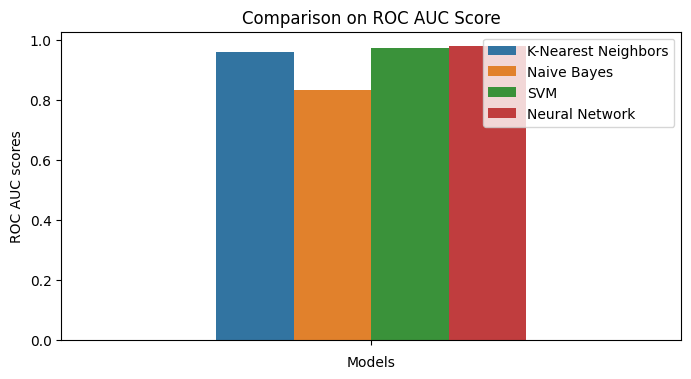

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

models, roc_auc_scores = zip(*roc_auc_results)

plt.figure(figsize=(8, 4))
sns.barplot(hue=models, y=roc_auc_scores, legend=True, width=0.5)
plt.title('Comparison on ROC AUC Score')
plt.xlabel('Models')
plt.ylabel('ROC AUC scores')
plt.show()

Sul modello con lo score più alto (Neural Network) andiamo a fare valutazioni aggiuntive:

**Valutazione con dataset pesato (visto che il target è molto sbilanciato)**

L'utilizzo del dataset bilanciato mostra un ulteriore miglioramento delle metriche risultanti dall'addestramento.

In [12]:
from imblearn.over_sampling import SMOTE
from sklearn.neural_network import MLPClassifier

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=RANDOM_SEED, stratify=Y)

smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

mlp = MLPClassifier(random_state=RANDOM_SEED)
mlp.fit(X_train_balanced, y_train_balanced)

y_pred_mlp = mlp.predict(X_test)
y_proba_mlp = mlp.predict_proba(X_test)[:, 1]

best_model = mlp

roc_auc_results.append(evaluate_model("Neural Network - Balanced", y_test, y_pred_mlp, y_proba_mlp))


Neural Network - Balanced


--> Classification Report:

              precision    recall  f1-score   support

           0       1.00      0.96      0.98     92611
           1       0.69      0.99      0.81      8917

    accuracy                           0.96    101528
   macro avg       0.84      0.97      0.89    101528
weighted avg       0.97      0.96      0.96    101528
 

--> Confusion Matrix:

[[88647  3964]
 [  108  8809]] 

--> ROC AUC Score:

0.9786476748074832 




**Valutazione presenza di overfitting**

Nel dataset di test si ottiene un punteggio ROC AUC che si discosta di 0.01, quindi non è indice di overfitting

In [13]:
from sklearn.metrics import roc_auc_score

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=RANDOM_SEED, stratify=Y)
smote = SMOTE(random_state=RANDOM_SEED)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

y_train_pred = best_model.predict(X_train_balanced)
y_train_proba = best_model.predict_proba(X_train_balanced)[:, 1]

y_test_pred = best_model.predict(X_test)
y_test_proba = best_model.predict_proba(X_test)[:, 1]

print_formatted("Best Model - Training Set", roc_auc_score(y_train_balanced, y_train_proba))
print_formatted("Best Model - Test Set", roc_auc_score(y_test, y_test_proba))


Best Model - Training Set
0.9866475074101508


Best Model - Test Set
0.9786476748074832




**Valutazione con cross-validation**

Variando le combinazioni di train e test set non risultano cali di precisione sul modello

In [14]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(best_model, X_train_balanced, y_train_balanced, cv=5, scoring='roc_auc')
print_formatted("Mean ROC AUC Score", cv_scores.mean())


Mean ROC AUC Score
0.9829397336827175



## Valutazione "BONUS"

Si devono determinare le variabili che concorrono a ritenere un cliente come "non affidabile". Si effettua una valutazione per il primo elemento del dataset di test.

In teoria per questo scopo è migliore il K-Nearest Neighbor, in quanto permette di vedere i "punti" vicini che concorrono a determinare il target.

Per quanto riguarda invece il Neural Network, è poco interpretabile, specie con un numero alto di layer. Si valuta tuttavia una tecnica detta SHAP (SHapley Additive exPlanations)che dovrebbe permettere di estrarre le features con maggiore impatto.



###K-Nearest Neighbor

Il rilevamento degli elementi vicini non è molto d'aiuto a giustificare la predizione del target, soprattutto se il numero di features è abbastanza elevato. Si vede tuttavia come gli elementi ritenuti vicini abbiano effettivamente valori standardizzati molto simili a quello usato per l'analisi.

In [15]:
import numpy as np

test_index = 0

distances, indices = best_knc.kneighbors(X_test.iloc[test_index].values.reshape(1, -1))

print_formatted(f"Evaluation on customer with index {test_index} of test dataset with K-Nearest Neighbor")

print(f"Customer data at {test_index+1}° place, with target: {y_test.iloc[test_index]}:")
print(pd.DataFrame([X_test.iloc[test_index]]).to_string(index=False))

print(f"\n* Closest elements that help prediction : {y_test.iloc[test_index]} *")
for i, index in enumerate(indices[0]):
    print(f"\nElement {i+1}:")
    print(pd.DataFrame([X_train.iloc[index]]).to_string(index=False))
    print(f"Label: {y_train.iloc[index]}")


Evaluation on customer with index 0 of test dataset with K-Nearest Neighbor


Customer data at 1° place, with target: 0:
 CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  NAME_EDUCATION_TYPE  FLAG_MOBIL  FLAG_WORK_PHONE  FLAG_PHONE  FLAG_EMAIL  CNT_FAM_MEMBERS  AGE_YEARS  YEARS_EMPLOYED  NAME_INCOME_TYPE_Pensioner  NAME_INCOME_TYPE_State servant  NAME_INCOME_TYPE_Student  NAME_INCOME_TYPE_Working  NAME_FAMILY_STATUS_Married  NAME_FAMILY_STATUS_Separated  NAME_FAMILY_STATUS_Single / not married  NAME_FAMILY_STATUS_Widow  NAME_HOUSING_TYPE_House / apartment  NAME_HOUSING_TYPE_Municipal apartment  NAME_HOUSING_TYPE_Office apartment  NAME_HOUSING_TYPE_Rented apartment  NAME_HOUSING_TYPE_With parents  OCCUPATION_TYPE_Cleaning staff  OCCUPATION_TYPE_Cooking staff  OCCUPATION_TYPE_Core staff  OCCUPATION_TYPE_Drivers  OCCUPATION_TYPE_HR staff  OCCUPATION_TYPE_High skill tech staff  OCCUPATION_TYPE_IT staff  OCCUPATION_TYPE_Laborers  OCCUPATION_TYPE_Low-skill Laborer

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


###Neural Network

Il grafico mostra le variabili che hanno avuto un maggior impatto (in negativo e in positivo) sulla predizione. In questo caso il valore previsto è di non affidabilità, dovuto per lo più al contributo negativo dell'età del soggetto. Tramite questa tenica possiamo identificare in maniera puntuale l'apporto delle varie features sul risultato finale.

In [16]:
!pip install shap
import shap

print_formatted(f"Evaluation on first customer of test dataset with Neural Network")

print(f"Customer data at first place, with target: {y_test.iloc[0]}:\n")
print(pd.DataFrame([X_test.iloc[0]]).to_string(index=False))

explainer = shap.KernelExplainer(mlp.predict_proba, X_train[:100])
shap_values = explainer.shap_values(X_test[:1])

shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[0, :, 1], X_test.iloc[0, :], feature_names=X_test.columns)


Evaluation on first customer of test dataset with Neural Network


Customer data at first place, with target: 0:

 CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  NAME_EDUCATION_TYPE  FLAG_MOBIL  FLAG_WORK_PHONE  FLAG_PHONE  FLAG_EMAIL  CNT_FAM_MEMBERS  AGE_YEARS  YEARS_EMPLOYED  NAME_INCOME_TYPE_Pensioner  NAME_INCOME_TYPE_State servant  NAME_INCOME_TYPE_Student  NAME_INCOME_TYPE_Working  NAME_FAMILY_STATUS_Married  NAME_FAMILY_STATUS_Separated  NAME_FAMILY_STATUS_Single / not married  NAME_FAMILY_STATUS_Widow  NAME_HOUSING_TYPE_House / apartment  NAME_HOUSING_TYPE_Municipal apartment  NAME_HOUSING_TYPE_Office apartment  NAME_HOUSING_TYPE_Rented apartment  NAME_HOUSING_TYPE_With parents  OCCUPATION_TYPE_Cleaning staff  OCCUPATION_TYPE_Cooking staff  OCCUPATION_TYPE_Core staff  OCCUPATION_TYPE_Drivers  OCCUPATION_TYPE_HR staff  OCCUPATION_TYPE_High skill tech staff  OCCUPATION_TYPE_IT staff  OCCUPATION_TYPE_Laborers  OCCUPATION_TYPE_Low-skill Laborers  OCCU

  0%|          | 0/1 [00:00<?, ?it/s]